In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Mar 12 2024

@author: Yaning
Data from Ben
Data file name: intertemporal_choice_dataset_all_trials.csv
"""
# functions for simulating agent data
# this file address is your own
%run Documents/pyro_models/files_to_run/data_analysis_without_version.ipynb

import math
import os
# from turtle import position
import torch
import torch.distributions.constraints as constraints
import pyro
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO, Predictive
from pyro.distributions import Beta, Binomial, HalfCauchy, Normal, Pareto, Uniform, Bernoulli, Categorical, Gamma
from tqdm import tqdm
import matplotlib.pyplot as plt
from statistics import mean 
# import pandas as pd
import numpy as np
import scipy.stats as stats 


['', 'trial', 'val_basic', 'delay', 'val_prc', 'response', 'RT', 'respSide', 'sideNOW', 'Version', 'loopID', 'Context']


In [5]:
run_data = data.reshape(60, 170, 8)

In [9]:
run_data.shape

torch.Size([60, 170, 8])

In [8]:
run_data = torch.tensor(run_data)

In [19]:
# model
def model_normal_log(data):
    num_groups = data.shape[0]
    num_trials_per_group = data.shape[1]
    mean_u_mean_q = pyro.param("mean_u_mean_q", torch.randn(num_groups))
    mean_u_sigma_q = pyro.param("mean_u_sigma_q", torch.ones(num_groups), constraint=constraints.positive)
    sigma_u_mean_q =  pyro.param("sigma_u_mean_q", torch.randn(num_groups))
    sigma_u_sigma_q =  pyro.param("sigma_u_sigma_q", torch.ones(num_groups), constraint=constraints.positive)
    sigma_es_mean_q = pyro.param("sigma_es_mean_q", torch.randn(num_groups))
    sigma_es_sigma_q = pyro.param("sigma_es_sigma_q", torch.ones(num_groups), constraint=constraints.positive)
    beta_mean_q = pyro.param("beta_mean_q", torch.randn(num_groups))
    beta_sigma_q = pyro.param("beta_sigma_q", torch.ones(num_groups), constraint=constraints.positive)

    # get individual samples
    with pyro.plate("group", num_groups):
        mean_u = pyro.sample("mean_u_", Normal(loc=mean_u_mean_q, scale=mean_u_sigma_q))
        log_sigma_u = pyro.sample("log_sigma_u_", Normal(loc=sigma_u_mean_q, scale = sigma_u_sigma_q))
        log_sigma_es = pyro.sample("log_sigma_es_", Normal(loc=sigma_es_mean_q, scale = sigma_es_sigma_q))
        beta = pyro.sample("beta", Normal(loc=beta_mean_q, scale = beta_sigma_q))
    
    # loop through all the data with group indices
    with pyro.plate("data", num_groups*num_trials_per_group):
        group_indices = torch.arange(num_groups).unsqueeze(1).repeat(1, num_trials_per_group).reshape(-1)

        sigma_u = torch.exp(log_sigma_u[group_indices])
        sigma_es = torch.exp(log_sigma_es[group_indices])
        e_val = (mean_u[group_indices]*data[:,:,2].view(-1)*sigma_es**2 + 
                 data[:,:,3].view(-1)*sigma_u**2)/(data[:,:,2].view(-1)*sigma_es**2 + sigma_u**2)


        softmax_args = torch.stack([beta[group_indices]*e_val, beta[group_indices]*data[:,:,1].view(-1)])
        p = torch.softmax(softmax_args, dim = 0)[0]
        pyro.sample("obs", Bernoulli(probs = p), obs=data[:,:,4].view(-1))


def guide_normal_log(data):
    num_groups = data.shape[0]
    mean_u_mean_q = pyro.param("mean_u_mean_q", torch.randn(num_groups))
    mean_u_sigma_q = pyro.param("mean_u_sigma_q", torch.ones(num_groups), constraint=constraints.positive)
    sigma_u_mean_q =  pyro.param("sigma_u_mean_q", torch.randn(num_groups))
    sigma_u_sigma_q =  pyro.param("sigma_u_sigma_q", torch.ones(num_groups), constraint=constraints.positive)
    sigma_es_mean_q = pyro.param("sigma_es_mean_q", torch.randn(num_groups))
    sigma_es_sigma_q = pyro.param("sigma_es_sigma_q", torch.ones(num_groups), constraint=constraints.positive)
    beta_mean_q = pyro.param("beta_mean_q", torch.randn(num_groups))
    beta_sigma_q = pyro.param("beta_sigma_q", torch.ones(num_groups), constraint=constraints.positive)
    
    # get individual samples
    with pyro.plate("group", data.shape[0]):
        mean_u = pyro.sample("mean_u_", Normal(loc=mean_u_mean_q, scale=mean_u_sigma_q))
        log_sigma_u = pyro.sample("log_sigma_u_", Normal(loc=sigma_u_mean_q, scale = sigma_u_sigma_q))
        log_sigma_es = pyro.sample("log_sigma_es_", Normal(loc=sigma_es_mean_q, scale = sigma_es_sigma_q))
        beta = pyro.sample("beta", Normal(loc=beta_mean_q, scale = beta_sigma_q))

Mean ELBO 3203.47: 100%|█████████████████████████████████████████| 400/400 [00:02<00:00, 194.11it/s]


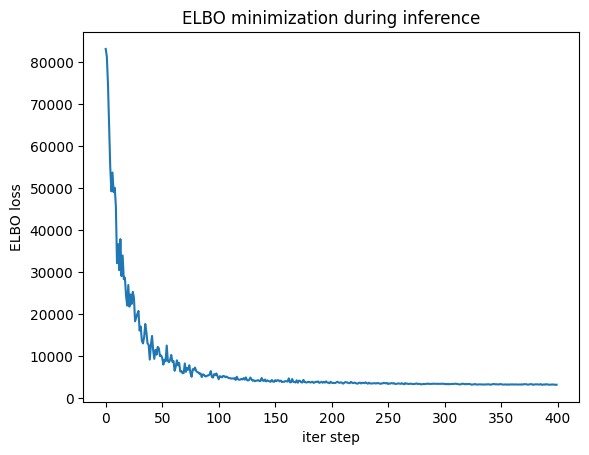

In [20]:
# this is for running the notebook in our testing framework
smoke_test = ('CI' in os.environ)
# the step was 2000
n_steps = 2 if smoke_test else 400

# assert pyro.__version__.startswith('1.8.6')

# clear the param store in case we're in a REPL
pyro.clear_param_store()# setup the optimizer
# the learning rate was 0.0005 , "betas": (0.90, 0.999)
adam_params = {"lr": 0.1}
optimizer = Adam(adam_params)
# setup the inference algorithm
svi = SVI(model_normal_log, guide_normal_log, optimizer, loss=Trace_ELBO())
# svi = SVI(model_gamma, guide_gamma, optimizer, loss=Trace_ELBO())

loss = []
pbar = tqdm(range(n_steps), position = 0)
# do gradient steps
for step in pbar:
    loss.append(torch.tensor(svi.step(run_data)))
    pbar.set_description("Mean ELBO %6.2f" % torch.tensor(loss[-20:]).mean())
    if torch.isnan(loss[-1]):
	    break

plt.figure()
plt.plot(loss)
plt.xlabel("iter step")
plt.ylabel("ELBO loss")
plt.title("ELBO minimization during inference")
plt.show()

In [21]:
posterior = {}
for name, value in pyro.get_param_store().items():
    posterior[name] = pyro.param(name)
    print(name, pyro.param(name))

mean_u_mean_q tensor([ 5.7689,  2.5833,  2.1513, 10.5264,  4.6003,  4.5940,  0.3859,  2.1733,
         1.5763,  1.0596,  4.9566,  1.5165, -0.3236,  8.3302,  1.3685,  2.4993,
         7.7659,  1.6331,  4.1248,  1.0081,  2.4661,  3.0301,  1.6903,  2.7764,
         3.8170,  5.3294,  1.3846,  1.4497,  4.0075,  3.1550,  1.4052,  2.7211,
         2.0473,  1.8714,  3.0747,  9.5826,  6.2144,  4.8059,  6.0428,  1.1142,
         0.0112,  1.6054,  2.8008,  3.0406,  1.2997,  7.0067,  3.0894,  1.8998,
         1.9125,  3.1482,  0.7969,  2.3860,  0.8997,  6.1321,  2.7026,  0.4285,
         1.3960,  1.0285,  5.0337,  5.3138], requires_grad=True)
mean_u_sigma_q tensor([1.2767, 0.3023, 0.5258, 1.8471, 0.7754, 0.3436, 0.4593, 0.3833, 0.2110,
        0.6935, 0.3359, 0.8189, 1.3735, 0.6638, 0.7183, 0.8720, 0.2007, 0.7557,
        0.2590, 0.4034, 0.4624, 0.3149, 0.7730, 0.3942, 0.1254, 0.4371, 0.7338,
        0.3367, 0.5041, 1.1147, 0.3209, 0.3700, 0.4190, 0.5526, 0.6459, 0.3142,
        0.7026, 0.4849, 0.

In [22]:
posterior

{'mean_u_mean_q': tensor([ 5.7689,  2.5833,  2.1513, 10.5264,  4.6003,  4.5940,  0.3859,  2.1733,
          1.5763,  1.0596,  4.9566,  1.5165, -0.3236,  8.3302,  1.3685,  2.4993,
          7.7659,  1.6331,  4.1248,  1.0081,  2.4661,  3.0301,  1.6903,  2.7764,
          3.8170,  5.3294,  1.3846,  1.4497,  4.0075,  3.1550,  1.4052,  2.7211,
          2.0473,  1.8714,  3.0747,  9.5826,  6.2144,  4.8059,  6.0428,  1.1142,
          0.0112,  1.6054,  2.8008,  3.0406,  1.2997,  7.0067,  3.0894,  1.8998,
          1.9125,  3.1482,  0.7969,  2.3860,  0.8997,  6.1321,  2.7026,  0.4285,
          1.3960,  1.0285,  5.0337,  5.3138], requires_grad=True),
 'mean_u_sigma_q': tensor([1.2767, 0.3023, 0.5258, 1.8471, 0.7754, 0.3436, 0.4593, 0.3833, 0.2110,
         0.6935, 0.3359, 0.8189, 1.3735, 0.6638, 0.7183, 0.8720, 0.2007, 0.7557,
         0.2590, 0.4034, 0.4624, 0.3149, 0.7730, 0.3942, 0.1254, 0.4371, 0.7338,
         0.3367, 0.5041, 1.1147, 0.3209, 0.3700, 0.4190, 0.5526, 0.6459, 0.3142,
       